# Experiment

## Install Python dependencies

In [32]:
!pip install onnx onnxruntime seaborn tf2onnx


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


Import the dependencies for the model training code:

In [33]:
import numpy as np
import pandas as pd
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path

## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [31]:
Data = pd.read_csv('data/card_transdata.csv')
Data.count()

distance_from_home                1000000
distance_from_last_transaction    1000000
ratio_to_median_purchase_price    1000000
repeat_retailer                   1000000
used_chip                         1000000
used_pin_number                   1000000
online_order                      1000000
fraud                             1000000
dtype: int64

In [21]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

X = Data.drop(columns = ['repeat_retailer','distance_from_home', 'fraud'])
y = Data['fraud']

# Split the data into training and testing sets so you have something to test the trained model with.

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [22]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                192       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                      

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [23]:
# Train the model and get performance
import os

epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val.values),y_val), \
                    verbose = True, class_weight = class_weights)
print("Training of model is complete")

Epoch 1/2
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2600 - accuracy: 0.9309 - val_loss: 0.2086 - val_accuracy: 0.9451
Epoch 2/2
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2376 - accuracy: 0.9474 - val_loss: 0.2130 - val_accuracy: 0.9502
Training of model is complete


## Save the model file

In [24]:
# Save the model as ONNX for easy use of ModelMesh
model_proto, _ = tf2onnx.convert.from_keras(model)

model_path="models"
os.makedirs(model_path, exist_ok=True)
model_name = "model.onnx"

onnx.save(model_proto, f"{model_path}/{model_name}")

2024-09-21 15:34:29.910823: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-21 15:34:29.910913: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-09-21 15:34:29.948301: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-21 15:34:29.948371: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [12]:
! ls -alRh ./models/

./models/:
total 24K
drwxr-sr-x.  2 1001210000 1001210000 4.0K Sep 19 20:38 .
drwxrwsr-x. 16 1001210000 1001210000 4.0K Sep 19 20:38 ..
-rw-r--r--.  1 1001210000 1001210000  13K Sep 19 20:38 model.onnx


## Test the model

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as rt

Load the test data and scaler:

In [26]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [27]:
sess = rt.InferenceSession(f"{model_path}/{model_name}", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: scaler.transform(X_test.values).astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.95
y_pred = np.where(y_pred_temp > threshold, 1,0)

Show the results:

Accuracy: 0.97536


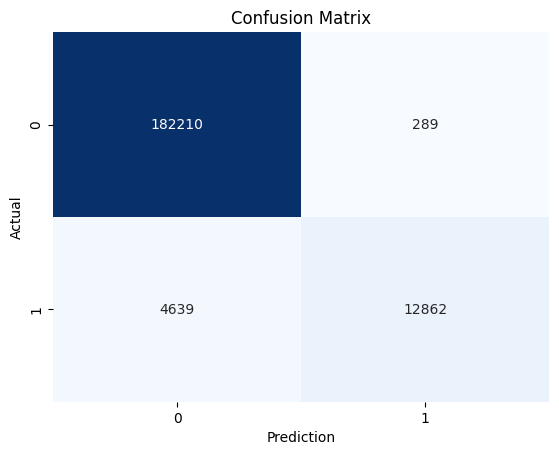

In [28]:
accuracy = np.sum(np.asarray(y_test) == y_pred) / len(y_pred)
print("Accuracy: " + str(accuracy))

c_matrix = confusion_matrix(np.asarray(y_test),y_pred)
ax = sns.heatmap(c_matrix, annot=True,fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [29]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(sally_transaction_details).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was Sally's transaction to be fraudulent? ")
print("{:.5f}".format(np.squeeze(prediction)) + "%")

Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely was Sally's transaction to be fraudulent? 
0.00023%
